In [1]:
import os
from os import path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from sklearn import svm
import PIL
import pickle
import cv2

In [3]:
data_dir = '../../data/v_0.1/'
train_dataset = path.join(data_dir, 'train.csv')
valid_dataset = path.join(data_dir, 'valid.csv')
test_dataset = path.join(data_dir, 'test.csv')

cols = [i for i in range(1025)]

train_df = pd.read_csv(train_dataset, header=0, names=cols)
valid_df = pd.read_csv(valid_dataset, header=0, names=cols)
test_df = pd.read_csv(test_dataset, header=0, names=cols)

In [3]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, :1]
y = np.array(y[0].tolist())

X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, :1]

X_valid = valid_df.iloc[:, 1:]
y_valid = valid_df.iloc[:, :1]

In [9]:
print('Train -', X.shape)
print('Valid -', X_valid.shape)
print('Test -', X_test.shape)

Train - (17235, 1024)
Valid - (5705, 1024)
Test - (6359, 1024)


In [84]:
clf = svm.SVC(kernel='rbf', gamma=0.01, max_iter=50, verbose=False)
clf.fit(X, y)

y_preds = clf.predict(X_test)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [85]:
y_test_list = y_test[0].tolist()
y_preds_list = list(y_preds)

pred_acc_list = []
for pred_class, true_class in zip(y_preds_list, y_test_list):
    pred_acc_list.append(int(pred_class==true_class))

accuracy = sum(pred_acc_list) / float(len(pred_acc_list)) * 100
print(f'Accuracy: {round(accuracy, 2)}%')

Accuracy: 77.1%


In [14]:
filename = 'svm_model_1.sav'
pickle.dump(clf, open(filename, 'wb'))

## Testing the model

In [165]:
def resize_image(img, channel=3):
    gray_img = img[:,:,channel]
    bin_img = gray_img / 25
    bin_img = cv2.resize(bin_img, (32, 32))
    bin_img = bin_img > 0
    return bin_img


image_cv2 = cv2.imread('../data/v_0.2/character_3351/58.png', cv2.IMREAD_UNCHANGED)
img_32X32 = resize_image(image_cv2)

In [133]:
img_32X32 = img_32X32.astype(int)
img_1X1024 = np.reshape(img_32X32, (1, 1024))

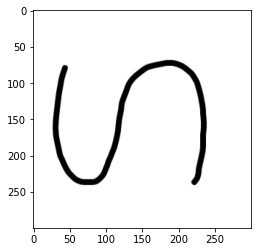

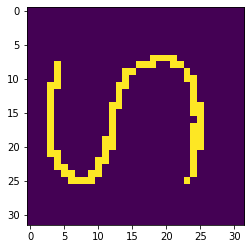

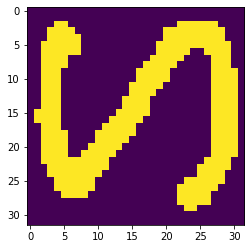

In [134]:
plt.figure('300 X 300 image')
plt.imshow(image_cv2)

plt.figure('32 X 32 image')
plt.imshow(img_32X32)

plt.figure('train image')
temp = np.reshape(np.array(train_df.values[4370][1:]), (32,32))
plt.imshow(temp)

In [135]:
img_test = img_1X1024
unique, counts = np.unique(img_test, return_counts=True)
print('Test image -', dict(zip(unique, counts)))

img_train = np.array(train_df.values[4370][1:])
unique, counts = np.unique(img_train, return_counts=True)
print('Train image -', dict(zip(unique, counts)))

Test image - {0: 943, 1: 81}
Train image - {0: 693, 1: 331}


In [136]:
result = clf.predict(img_1X1024)
result

array([56])

## Flipping and rotating the dataset

In [4]:
def rotate_flip(img_array):
    angle = 270 
    data = np.reshape(img_array, (32,32))

    new_data = ndimage.rotate(data, angle, reshape=True)
    new_data = np.fliplr(new_data)
    
    new_data = np.reshape(new_data, (1, 1024))
    return new_data

def rotate_and_flip_dataset(dataset):
    new_df_list = []
    
    for row in dataset.values:
        new_row = []
        new_row.append(row[0])
        row = rotate_flip(row[1:])
        new_row += row.tolist()[0]
        new_df_list.append(new_row)
    
    return new_df_list

In [7]:
new_train = rotate_and_flip_dataset(train_df)
train_df = pd.DataFrame(new_train)
train_df.to_csv('fixed_train.csv')

new_test = rotate_and_flip_dataset(test_df)
test_df = pd.DataFrame(new_test)
test_df.to_csv('fixed_test.csv')

new_valid = rotate_and_flip_dataset(valid_df)
valid_df = pd.DataFrame(new_valid)
valid_df.to_csv('fixed_valid.csv')

In [8]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(17235, 1025)
(5705, 1025)
(6359, 1025)


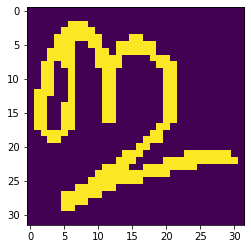

In [79]:
temp = np.reshape(np.array(test_df.values[1000][1:]), (32,32))
plt.imshow(temp)

In [15]:
l = [1, 2, 4]
a = l.pop(0)
a, l

(1, [2, 4])

In [21]:
a = np.array([1, 2, 3])
b = np.array([0])
c = a+b
print(c)

[1 2 3]


In [22]:
new_list = []
for row in train_df.values:
    new_list.append(row[0])
    a = a.tolist()
    print(new_list + a)
    break

[1, 1, 2, 3]


### Retraining with new dataset

In [144]:
new_df_list = []

for i in range(91):
    image_cv2 = cv2.imread(f'tr/{i+1}.png', cv2.IMREAD_UNCHANGED)
    img_32X32 = resize_image(image_cv2)
    img_32X32 = img_32X32.astype(int)
    img_1X1024 = np.reshape(img_32X32, (1, 1024))
    row = np.insert(img_1X1024[0], 0, 22)
    new_df_list.append(row.tolist())

In [146]:
new_X = pd.DataFrame(new_df_list)

In [147]:
new_train_df = train_df.append(new_X)
print(train_df.shape)
print(new_train_df.shape)

(17235, 1025)
(17326, 1025)


In [148]:
X = new_train_df.iloc[:, 1:]
y = new_train_df.iloc[:, :1]
y = np.array(y[0].tolist())

X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, :1]

clf = svm.SVC(kernel='rbf', gamma=0.01, max_iter=50, verbose=False)
clf.fit(X, y)

y_preds = clf.predict(X_test)

y_test_list = y_test[0].tolist()
y_preds_list = list(y_preds)

pred_acc_list = []
for pred_class, true_class in zip(y_preds_list, y_test_list):
    pred_acc_list.append(int(pred_class==true_class))

accuracy = sum(pred_acc_list) / float(len(pred_acc_list)) * 100
print(f'Accuracy: {round(accuracy, 2)}%')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Accuracy: 76.96%


In [156]:
preds = []
for i in range(39):
    image_cv2 = cv2.imread(f'te/{i+1}.png', cv2.IMREAD_UNCHANGED)
    img_32X32 = resize_image(image_cv2)
    img_32X32 = img_32X32.astype(int)
    img_1X1024 = np.reshape(img_32X32, (1, 1024))
    result = clf.predict(img_1X1024)
    preds.append(result[0])

print(preds)

[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22]


In [183]:
image_cv2 = cv2.imread('proper_test2.png', cv2.IMREAD_UNCHANGED)
image_cv2 = cv2.bitwise_not(image_cv2)
img_32X32 = resize_image(image_cv2, channel=3)
img_32X32 = img_32X32.astype(int)
img_1X1024 = np.reshape(img_32X32, (1, 1024))
result = clf.predict(img_1X1024)

In [184]:
result

array([22])

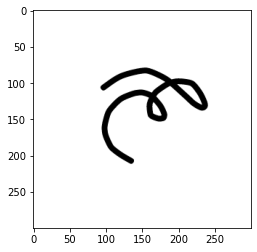

In [26]:
i = cv2.imread('../../data/v_0.2/train/59/88.png', cv2.IMREAD_UNCHANGED)
plt.imshow(i)